<a href="https://colab.research.google.com/github/reggiebain/data-projects/blob/main/Predicting_Play_Calls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Play Calls for South Carolina Offense
- Utilize cfbd API
- Step 1: Use classical ML to make play call predictor using play calling data
- Following the model of https://blog.collegefootballdata.com/talking-tech-predicting-play-calls-using-a-random-forest-classifier/ 

In [1]:
!pip install cfbd;
!pip install seaborn --upgrade;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 288 kB 4.7 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [2]:
import cfbd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests

In [13]:
# Set up configuration with my personal API key
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'Ij+eNjYM+2AGnCzUarYtgy6ojR4W9W6iDuenMXna2jS+LmxUOHh6M1uBP+5NIz/Z'
configuration.api_key_prefix['Authorization'] = 'Bearer'

api_config = cfbd.ApiClient(configuration)

In [21]:
# Create function to get plays using the CFBD API
def getplays(api, years, weeks, offense):
  plays = []
  for year in years:
    for week in weeks:    
      plays += api.get_plays(year=year, week=week, offense=offense)
  return plays

# Create function to parse the plays into a dataframe
def plays_to_df(plays): 
  plays_dict = [dict(
    game_id = p.game_id,
    play_id = p.id,
    home = p.home,
    away = p.away,
    offense_score = p.offense_score,
    defense_score = p.defense_score,
    period = p.period,
    clock_minutes = p.clock.minutes,
    clock_seconds = p.clock.seconds,
    s = p.clock.seconds,
    yards_to_goal = p.yards_to_goal,
    down = p.down,
    distance = p.distance,
    play_type = p.play_type
  ) for p in plays if p.play_type is not None]
  plays_df = pd.DataFrame(plays_dict)
  return plays_df   

In [25]:
# Get South Carolina Plays from weeks 2-3 from 2018,2019
plays_api = cfbd.PlaysApi(api_config)
years = list(range(2016,2020,1))
weeks = list(range(1,12,1))
offense = 'South Carolina'
plays = getplays(plays_api, years, weeks, offense)
plays[0]

# Return a dataframe of the plays
plays_df = plays_to_df(plays)
plays_df.head()

,game_id,play_id,home,away,offense_score,defense_score,period,clock_minutes,clock_seconds,s,yards_to_goal,down,distance,play_type
0,400868968,400868968101854401,Vanderbilt,South Carolina,0,0,1,14,55,55,75,1,10,Penalty
1,400868968,400868968101857801,Vanderbilt,South Carolina,0,0,1,14,21,21,85,1,20,Rush
2,400868968,400868968101859501,Vanderbilt,South Carolina,0,0,1,14,4,4,89,2,24,Rush
3,400868968,400868968101866601,Vanderbilt,South Carolina,0,0,1,13,33,33,75,3,10,Pass Reception
4,400868968,400868968101868002,Vanderbilt,South Carolina,0,0,1,13,19,19,63,1,10,Penalty


In [26]:
plays_df.shape

(3450, 14)

In [27]:
plays_df.away.unique()

array(['South Carolina', 'East Carolina', 'Texas A&M', 'Georgia', 'UMass',
       'Tennessee', 'Missouri', 'NC State', 'Kentucky', 'Louisiana Tech',
       'Arkansas', 'Vanderbilt', 'Florida', 'Coastal Carolina',
       'Charleston Southern', 'Alabama', 'Appalachian State'],
      dtype=object)

In [28]:
# Create categorical variable one hot to say whether or not USC is at home (since this could influence play calling)
plays_df['is_home'] = np.where(plays_df['home'] == 'South Carolina', 1, 0)

In [35]:
# Create feature of seconds on the clock rather than minutes and seconds left in game including quarters
plays_df['seconds_remaining'] = plays_df['clock_minutes']*60 + plays_df['clock_seconds'] + (4-plays_df['period'])*15*60

In [36]:
plays_df['play_type'].unique()

array(['Rush', 'Pass Reception', 'Pass Incompletion', 'Punt',
       'Field Goal Good', 'Rushing Touchdown', 'Sack',
       'Field Goal Missed', 'Pass Interception Return',
       'Passing Touchdown', 'Blocked Punt',
       'Interception Return Touchdown'], dtype=object)

In [37]:
# Engineer categorical variable of: Rush, Pass, FG, Punt (using hints from link)
# For now, classify other things as none such as penalties


def get_play_category(play):
  passes = ['Pass Reception', 'Pass Incompletion', 'Passing Touchdown','Pass Interception Return', 'Sack', 'Interception Return Touchdown']
  rushes = ['Rush', 'Rushing Touchdown']
  punts =  ['Punt', 'Punt Return Touchdown', 'Blocked Punt', 'Blocked Punt Touchdown']
  fgs = ['Field Goal Good', 'Field Goal Missed', 'Blocked Field Goal']

  if play in passes:
    return 'pass'
  elif play in rushes:
    return 'rush'
  elif play in punts:
    return 'punt'
  elif play in fgs:
    return 'fg'
  else:
    return None

plays_df['play_call'] = plays_df['play_type'].apply(get_play_category) # Apply our function to create categorical variable
plays_df.dropna(subset=['play_call'], inplace=True)# Remove play calls that fall outside these categories
plays_df.head()            

,game_id,play_id,home,away,offense_score,defense_score,period,clock_minutes,clock_seconds,s,yards_to_goal,down,distance,play_type,is_home,seconds_remaining,play_call
1,400868968,400868968101857801,Vanderbilt,South Carolina,0,0,1,14,21,21,85,1,20,Rush,0,3561,rush
2,400868968,400868968101859501,Vanderbilt,South Carolina,0,0,1,14,4,4,89,2,24,Rush,0,3544,rush
3,400868968,400868968101866601,Vanderbilt,South Carolina,0,0,1,13,33,33,75,3,10,Pass Reception,0,3513,pass
6,400868968,400868968101874201,Vanderbilt,South Carolina,0,0,1,12,57,57,74,1,21,Rush,0,3477,rush
7,400868968,400868968101876201,Vanderbilt,South Carolina,0,0,1,12,37,37,73,2,19,Pass Incompletion,0,3457,pass


In [38]:
# Create numerical encoding of play calls using factorize, this will nicely store the values
codes, uniques = pd.factorize(plays_df['play_call'])
plays_df['play_call'] = codes
plays_df.head()

,game_id,play_id,home,away,offense_score,defense_score,period,clock_minutes,clock_seconds,s,yards_to_goal,down,distance,play_type,is_home,seconds_remaining,play_call
1,400868968,400868968101857801,Vanderbilt,South Carolina,0,0,1,14,21,21,85,1,20,Rush,0,3561,0
2,400868968,400868968101859501,Vanderbilt,South Carolina,0,0,1,14,4,4,89,2,24,Rush,0,3544,0
3,400868968,400868968101866601,Vanderbilt,South Carolina,0,0,1,13,33,33,75,3,10,Pass Reception,0,3513,1
6,400868968,400868968101874201,Vanderbilt,South Carolina,0,0,1,12,57,57,74,1,21,Rush,0,3477,0
7,400868968,400868968101876201,Vanderbilt,South Carolina,0,0,1,12,37,37,73,2,19,Pass Incompletion,0,3457,1


In [39]:
# Remove unengineered features
df = plays_df[['offense_score', 'defense_score', 'period', 'yards_to_goal', 'down', 'distance', 'is_home', 'seconds_remaining', 'play_call']]
df.head()

,offense_score,defense_score,period,yards_to_goal,down,distance,is_home,seconds_remaining,play_call
1,0,0,1,85,1,20,0,3561,0
2,0,0,1,89,2,24,0,3544,0
3,0,0,1,75,3,10,0,3513,1
6,0,0,1,74,1,21,0,3477,0
7,0,0,1,73,2,19,0,3457,1


In [40]:
df.shape

(2871, 9)

### Building RF Classifier 

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(df.drop(['play_call'], axis=1), df['play_call'], test_size=0.2)

In [42]:
rf = RandomForestClassifier(random_state=123)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=123)

In [43]:
y_pred = rf.predict(X_test)

In [44]:
# Display proabilities of each of the test set plays to be each of the categories (pass, rush, etc.)
rf.predict_proba(X_test)[0:10]

array([[0.11, 0.25, 0.51, 0.13],
       [0.44, 0.56, 0.  , 0.  ],
       [0.68, 0.32, 0.  , 0.  ],
       [0.32, 0.68, 0.  , 0.  ],
       [0.05, 0.01, 0.92, 0.02],
       [0.77, 0.22, 0.  , 0.01],
       [0.24, 0.74, 0.02, 0.  ],
       [0.42, 0.58, 0.  , 0.  ],
       [0.03, 0.17, 0.77, 0.03],
       [0.39, 0.61, 0.  , 0.  ]])

In [45]:
# Using keys from factorizer let's get the predicted play calls
y_pred_calls = uniques[y_pred] # Get names of calls for predictions
y_test_calls = uniques[y_test]

In [46]:
# Use sklearn crosstab to get classification report
pd.crosstab(y_test_calls, y_pred_calls, rownames=['Actual Calls'], colnames=['Predicted Calls'])

Predicted Calls,fg,pass,punt,rush
Actual Calls,,,,
fg,5,4,0,1
pass,0,191,0,85
punt,0,1,42,2
rush,1,83,1,159


Accuracy Score = 0.6904347826086956
              precision    recall  f1-score   support

          fg       0.83      0.50      0.62        10
        pass       0.68      0.69      0.69       276
        punt       0.98      0.93      0.95        45
        rush       0.64      0.65      0.65       244

    accuracy                           0.69       575
   macro avg       0.78      0.69      0.73       575
weighted avg       0.69      0.69      0.69       575



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


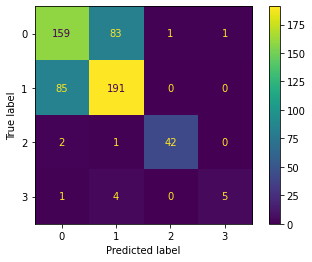

In [47]:
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score
print(f'Accuracy Score = {accuracy_score(y_test_calls, y_pred_calls)}')
print(classification_report(y_test_calls, y_pred_calls))
plot_confusion_matrix(rf, X_test, y_test)

In [48]:
list(zip(X_train, rf.feature_importances_))

[('offense_score', 0.10371013415778689),
 ('defense_score', 0.09902229373154386),
 ('period', 0.03336092299123948),
 ('yards_to_goal', 0.23686034938856154),
 ('down', 0.19818173828089367),
 ('distance', 0.10814974639593376),
 ('is_home', 0.02408935307722234),
 ('seconds_remaining', 0.1966254619768185)]

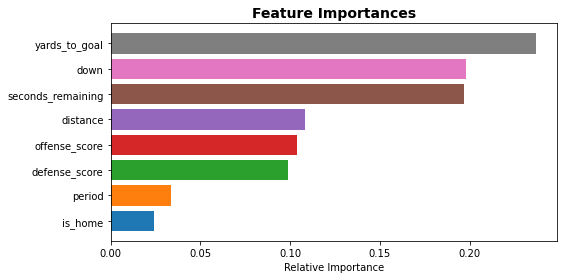

In [51]:
# Look at feature importances
import matplotlib as mpl
def graph_feature_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:] # Get top 10 most important features
    features = X_train.columns
    f, ax = plt.subplots(figsize=(8, 4))
    plt.title('Feature Importances', fontweight='bold', fontsize=14)
    cmap = plt.cm.get_cmap('tab10')
    colors = cmap(np.arange(cmap.N))
    plt.barh(range(len(indices)), importances[indices], color = cmap.colors)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
graph_feature_importance(rf) 